# Import Modules

In [1]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as anim
import typing as tp
import time
import random
import math
from collections import deque
from dataclasses import dataclass

import torch
from torch import nn, Tensor

SEED = 42 # SEED MATTERS A LOT!!! Change it and it might not work anymore
random.seed(SEED)
np.random.seed(SEED+1)
torch.manual_seed(SEED+2)
torch.use_deterministic_algorithms(mode=True, warn_only=False)

# Ops

In [2]:
def plot_environment(env:gym.Env, figsize:tuple[int, int]=(5, 4)):
    plt.figure(figsize=figsize)
    img = env.render()
    plt.imshow(img)
    plt.axis("off")
    return img

def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames:list, repeat=False, interval=40):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    animation = anim.FuncAnimation(
        fig, update_scene, fargs=(frames, patch),
        frames=len(frames), repeat=repeat, interval=interval)
    return animation

def show_one_episode(action_sampler:tp.Callable, n_max_steps=500, repeat=False):
    frames = []
    env = gym.make("CartPole-v1", render_mode="rgb_array")
    obs, info = env.reset()
    with torch.no_grad():
        for step in range(n_max_steps):
            frames.append(env.render())
            action = action_sampler(obs).cpu().item()
            obs, reward, done, truncated, info = env.step(action)
            if done or truncated:
                print("done at step", step+1)
                break
    env.close()
    return plot_animation(frames, repeat=repeat)

In [3]:
class CosineDecayWithWarmup:
    def __init__(
        self,
        warmup_steps:int,
        max_learning_rate:float,
        decay_steps:int,
        min_learning_rate:float
    ):
        self.warmup_steps = warmup_steps
        self.max_learning_rate = max_learning_rate
        self.decay_steps = decay_steps
        self.min_learning_rate = min_learning_rate

    def __call__(self, step):
        # linear warmup for warmup_steps steps
        if step < self.warmup_steps:
            return self.max_learning_rate * step / self.warmup_steps
        # if it > decay_steps, return min learning rate
        if step > self.decay_steps:
            return self.min_learning_rate
        # in between, use cosine decay down to min learning rate
        decay_ratio = (step - self.warmup_steps) / (self.decay_steps - self.warmup_steps)
        coeff = 0.5 * (1.0 + math.cos(math.pi * decay_ratio))
        return self.min_learning_rate + coeff * (self.max_learning_rate - self.min_learning_rate)

In [4]:
env = gym.make("CartPole-v1", render_mode="rgb_array")
obs, info = env.reset(seed=1)
obs, obs.shape, info

(array([ 0.00118216,  0.04504637, -0.03558404,  0.04486495], dtype=float32),
 (4,),
 {})

# Cartpole Environment
* GOAL: Keep the pole upright for as long as possible
```python
Actions:
    left: 0
    right: 1

Observation Space: (4,)
```
![image.png](images/carpole_info.png)
* The cart x-position (index 0) can be take values between (-4.8, 4.8), but the episode terminates if the cart leaves the (-2.4, 2.4) range.
* The pole angle can be observed between (-.418, .418) radians (or ±24°), but the episode terminates if the pole angle is not in the range (-.2095, .2095) (or ±12°)

## Rewards
* Since the goal is to keep the pole upright for as long as possible, a reward of +1 for every step taken, including the termination step, is allotted

## Episode End
* The episode ends if any one of the following occurs:
    * Termination: Pole Angle is greater than ±12°
    * Termination: Cart Position is greater than ±2.4 (center of the cart reaches the edge of the display)
    * Truncation: Episode length is greater than 500

# Expected Sarsa

In [5]:
@dataclass
class config:
    num_iters:int = 600
    num_episodes_per_iter:int = 10
    max_steps_per_episode:int = 1000 # will not go beyond 500, simply...
    
    gamma:float = 0.99 # changed from 0.95, improved performance...
    
    lr:float = 0.01
    weight_decay:float = 0.0
    batch_size:int = 64
    constlr_steps:int = int(num_iters*0.4375)

    device:torch.device = torch.device("cuda" if False else "cpu") # cpu good for very very small models
    dtype:torch.dtype = torch.float32 if "cpu" in device.type else torch.float16

    autocast:torch.autocast = torch.autocast(
        device_type=device.type, dtype=dtype, enabled="cuda" in device.type
    )
    logging_interval:int = 1

    generator:torch.Generator = torch.Generator(device=device).manual_seed(SEED+343434)

print(config())

config(num_iters=600, num_episodes_per_iter=10, max_steps_per_episode=1000, gamma=0.99, lr=0.01, weight_decay=0.0, batch_size=64, constlr_steps=262, device=device(type='cpu'), dtype=torch.float32, autocast=<torch.amp.autocast_mode.autocast object at 0x74e80e5057d0>, logging_interval=1, generator=<torch._C.Generator object at 0x74e80eaff370>)


In [6]:
class DQN(nn.Module):
    def __init__(self, num_inputs:int, num_hidden:int, num_outputs:int):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(num_inputs, num_hidden), nn.ELU(),
            nn.Linear(num_hidden, num_hidden), nn.ELU(),
            nn.Linear(num_hidden, num_outputs)
        )
        self.num_actions = num_outputs

    def forward(self, x:Tensor):      # (B, num_inputs=4)
        return self.model(x)          # (B, num_outputs=2)

In [7]:
dqn = DQN(
    num_inputs=env.observation_space.shape[0],
    num_hidden=32,
    num_outputs=env.action_space.n
)
dqn.to(config.device)
# dqn.compile()

optimizer = torch.optim.NAdam(
    dqn.parameters(),
    lr=config.lr,
    weight_decay=config.weight_decay,
)
cosine_decay = CosineDecayWithWarmup(
    warmup_steps=1,
    max_learning_rate=config.lr,
    decay_steps=config.num_iters,
    min_learning_rate=config.lr*0.0
)
def get_lr(step:int):
    if step < config.constlr_steps:
        return config.lr
    return cosine_decay(step)
    
print(len(list(dqn.parameters())), sum(p.numel() for p in dqn.parameters()), sep="\nNumber of parameters: ")

6
Number of parameters: 1282


In [8]:
@torch.no_grad()
def action_policy(dqn:DQN, obs:np.ndarray, epsilon:float) -> Tensor:
    if random.random() <= epsilon: return torch.randint(low=0, high=dqn.num_actions, size=(1,), device=config.device, generator=config.generator)
    else: return dqn(torch.as_tensor(obs, device=config.device).unsqueeze(0)).squeeze(0).argmax()

In [9]:
def play_step(dqn:DQN, obs:np.ndarray, eps:float, replay_buffer:deque):
    action = action_policy(dqn, obs, eps).item()
    next_obs, reward, done, truncated, info = env.step(action)
    # done = done or truncated # terminate only if done, not truncated
    replay_buffer.append([next_obs, action, reward, obs, done])
    return next_obs, reward, done, truncated, info

def sample_instances_from_buffer(replay_buffer:deque, batch_size:int):
    batch_sample = random.sample(replay_buffer, batch_size) # [[s', a, r, s], [s', a, r, s], ...] with len `batch_size`
    return batch_sample

![image.png](images/semi_grad_sarsa.png)

Some changes in the sarsa algorithm to get expected sarsa algorithm
 
![Expected sarsa](images/expected_sarsa.png)

In [10]:
@torch.compile
def train_step(dqn:DQN, replay_buffer:deque):
    # sample instances
    batched_samples = sample_instances_from_buffer(replay_buffer, batch_size=config.batch_size)
    instances = list(zip(*batched_samples))
    next_obs, actions, rewards, current_states, dones = [torch.as_tensor(np.array(inst), device=config.device, dtype=torch.float32) for inst in instances]
    # input model
    with torch.no_grad():
        with config.autocast:
            next_Q_val:Tensor = dqn(next_obs) # (B, num_actions)
            action_probs = next_Q_val.softmax(dim=1) # (B, num_actions)
            expected_Q_val = (next_Q_val*action_probs).sum(dim=1) # (B,)
            #for the condition from the algorithm above
            zero_if_terminal_else_one = (~(dones.bool())).float() # 0 if done else 1
    
        Qtarget:Tensor = (rewards + config.gamma * expected_Q_val * zero_if_terminal_else_one) # (B,)
    
    with config.autocast:
        Qpred:Tensor = dqn(current_states)
        Qpred = Qpred.gather(1, actions.unsqueeze(1).long()).squeeze(-1) # (B,)
        loss = nn.functional.mse_loss(Qpred, Qtarget)
    loss.backward()
    grads = [param.grad for param in dqn.parameters()]; dqn.zero_grad()
    return grads # len = 6

## Algorithm Structure
```python
* init replay_buffer
* iter episodes
    * init epsilon, lr
    * init all_grads all_rewards-td

    * iter avg_over
        * reset env
        * init current_rewards

        * iter max_steps
            * play step | append next_obs, action, reward, obs, done
            * append reward to current_rewards
            * break if done or truncated

        * train_step to get grads and append to all_grads
        * append current_rewards to all_rewards

    * compute avg_epsode_length and append it to episode_lengths
    * some logging
    * apply_grads to all_grads
```

In [11]:
def apply_grads(grads:list[list[Tensor]]): # (num_episodes_per_iter=10, 6)
    param_list_len = len(grads[0]) # 6
    to_be_applied_grads:list[list[Tensor]] = [[] for _ in range(param_list_len)] # initialize list

    for n_ep_per_iter, grads_in_ep in enumerate(grads):
        for i, grad in enumerate(grads_in_ep): # (6,)
            to_be_applied_grads[i].append(grad)

    grads:list[Tensor] = [torch.stack(grad_list).mean(dim=0) for grad_list in to_be_applied_grads]
    
    for p, grad in zip(dqn.parameters(), grads):
        p.grad = grad

    optimizer.step()
    optimizer.zero_grad()

def play():
    replay_buffer = deque(maxlen=config.num_iters*config.num_episodes_per_iter*config.max_steps_per_episode)
    episode_lens = []
    # Iter Episodes
    for iter_num in range(1, config.num_iters+1):
        # `else 0.01` works better than `else 0.0`
        epsilon = 0.1 if iter_num<180 else 0.01; t0 = time.time()
        all_grads = []   # (num_episodes_per_iter, 6)
        all_rewards = [] # (num_episodes_per_iter, max_steps_per_episode)

        lr = get_lr(iter_num)
        for param_group in optimizer.param_groups:
            param_group["lr"] = lr

        for episode in range(config.num_episodes_per_iter): # 10
            obs, info = env.reset(); current_rewards = []
            for step in range(config.max_steps_per_episode):
                obs, reward, done, truncated, _ = play_step(dqn, obs, epsilon, replay_buffer)
                current_rewards.append(reward)
                if done or truncated: break
        
            # train step to get grads
            if len(replay_buffer) > config.batch_size:
                grads = train_step(dqn, replay_buffer)
                all_grads.append(grads) # (num_episodes_per_iter, 6)

            all_rewards.append(current_rewards)

        # some logging
        episode_len_avg = sum(map(len, all_rewards))/config.num_episodes_per_iter; t1 = time.time(); dt = t1-t0
        episode_lens.append(episode_len_avg)
        if iter_num % config.logging_interval == 0:
            print(f"| Step: {iter_num:<4}/ {config.num_iters:<4} || Average Episode Length {episode_len_avg:<6.2f} || lr: {lr:<12e} || dt: {dt:<5.2f}s |")     

        # average gradients and apply them to increase the stability of the model (idk if this is usually done but it seems like a good idea)
        apply_grads(all_grads)
    return episode_lens

episode_lens = play()

[W1006 20:38:01.486216107 PyInterpreter.cpp:256] Warning: Deallocating Tensor that still has live PyObject references.  This probably happened because you took out a weak reference to Tensor and didn't call _fix_weakref() after dereferencing it.  Subsequent accesses to this tensor via the PyObject will now fail. (function decref)
[W1006 20:38:01.486234358 PyInterpreter.cpp:256] Warning: Deallocating Tensor that still has live PyObject references.  This probably happened because you took out a weak reference to Tensor and didn't call _fix_weakref() after dereferencing it.  Subsequent accesses to this tensor via the PyObject will now fail. (function decref)
[W1006 20:38:01.486239668 PyInterpreter.cpp:256] Warning: Deallocating Tensor that still has live PyObject references.  This probably happened because you took out a weak reference to Tensor and didn't call _fix_weakref() after dereferencing it.  Subsequent accesses to this tensor via the PyObject will now fail. (function decref)
[W10

| Step: 1   / 600  || Average Episode Length 10.10  || lr: 1.000000e-02 || dt: 14.39s |


[W1006 20:38:08.296316656 PyInterpreter.cpp:256] Warning: Deallocating Tensor that still has live PyObject references.  This probably happened because you took out a weak reference to Tensor and didn't call _fix_weakref() after dereferencing it.  Subsequent accesses to this tensor via the PyObject will now fail. (function decref)
[W1006 20:38:08.296329347 PyInterpreter.cpp:256] Warning: Deallocating Tensor that still has live PyObject references.  This probably happened because you took out a weak reference to Tensor and didn't call _fix_weakref() after dereferencing it.  Subsequent accesses to this tensor via the PyObject will now fail. (function decref)
[W1006 20:38:08.296332277 PyInterpreter.cpp:256] Warning: Deallocating Tensor that still has live PyObject references.  This probably happened because you took out a weak reference to Tensor and didn't call _fix_weakref() after dereferencing it.  Subsequent accesses to this tensor via the PyObject will now fail. (function decref)
[W10

| Step: 2   / 600  || Average Episode Length 9.30   || lr: 1.000000e-02 || dt: 9.86 s |
| Step: 3   / 600  || Average Episode Length 9.60   || lr: 1.000000e-02 || dt: 0.01 s |
| Step: 4   / 600  || Average Episode Length 9.90   || lr: 1.000000e-02 || dt: 0.01 s |
| Step: 5   / 600  || Average Episode Length 9.60   || lr: 1.000000e-02 || dt: 0.01 s |
| Step: 6   / 600  || Average Episode Length 9.70   || lr: 1.000000e-02 || dt: 0.01 s |
| Step: 7   / 600  || Average Episode Length 10.70  || lr: 1.000000e-02 || dt: 0.01 s |
| Step: 8   / 600  || Average Episode Length 9.40   || lr: 1.000000e-02 || dt: 0.01 s |
| Step: 9   / 600  || Average Episode Length 10.40  || lr: 1.000000e-02 || dt: 0.01 s |
| Step: 10  / 600  || Average Episode Length 10.60  || lr: 1.000000e-02 || dt: 0.01 s |
| Step: 11  / 600  || Average Episode Length 9.70   || lr: 1.000000e-02 || dt: 0.01 s |
| Step: 12  / 600  || Average Episode Length 9.60   || lr: 1.000000e-02 || dt: 0.01 s |
| Step: 13  / 600  || Average Ep

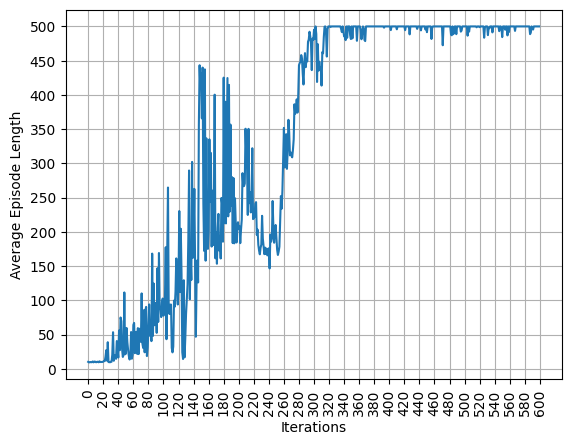

In [12]:
plt.plot(episode_lens)
plt.xlabel("Iterations")
plt.ylabel("Average Episode Length")
plt.yticks(range(0, 501, 50))
plt.xticks(range(0, config.num_iters+1, 20), rotation=90)
plt.grid(True)
plt.show() # SEED MATTERS A LOT!!!

done at step 500


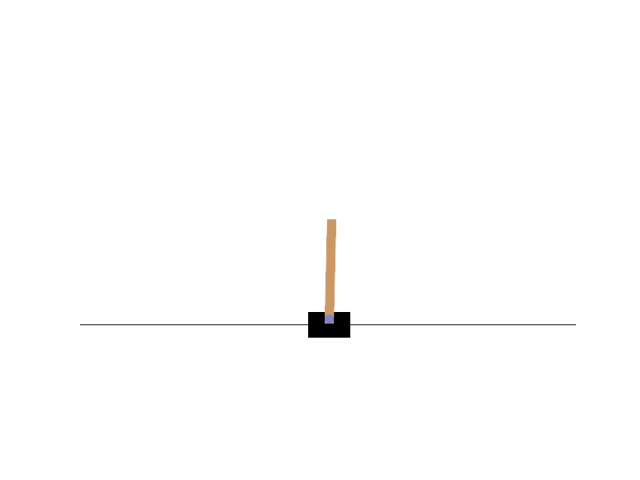

In [13]:
%matplotlib ipympl
show_one_episode(lambda obs: action_policy(dqn, obs, epsilon=0), repeat=False)

done at step 500


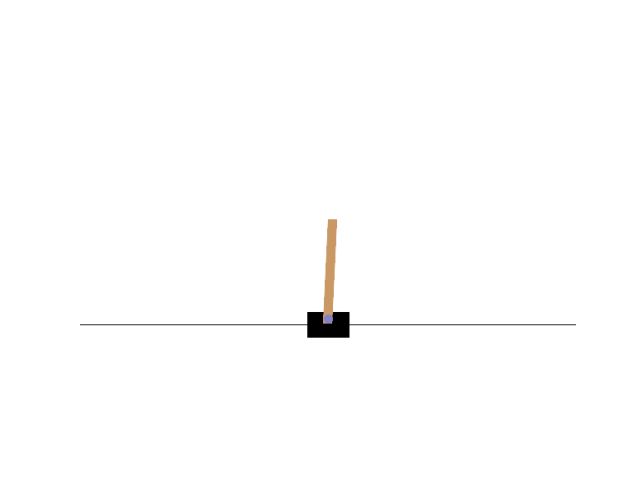

In [16]:
%matplotlib ipympl
show_one_episode(lambda obs: action_policy(dqn, obs, epsilon=0), repeat=False)

done at step 500


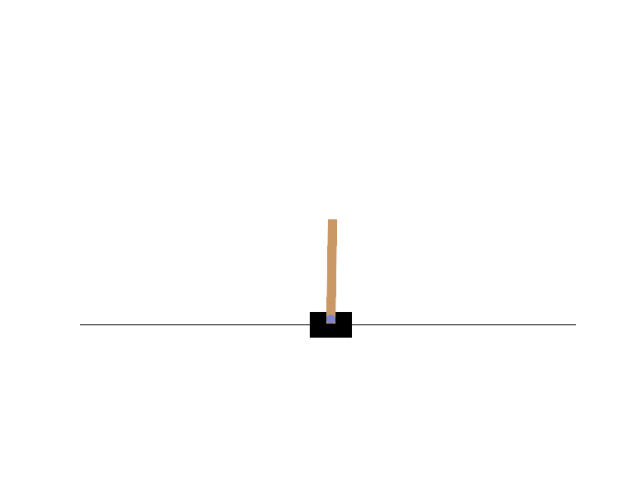

In [17]:
%matplotlib ipympl
show_one_episode(lambda obs: action_policy(dqn, obs, epsilon=0), repeat=False)